In [37]:
import os
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from tqdm.notebook import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
from torchvision import transforms, utils

np.random.seed(42)
%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.003
TRAIN_DATA_PATH = "dataset_divided/train"
TEST_DATA_PATH = "dataset_divided/test"

class ToNorm(object):
    def __call__(self,img):
        mean = torch.mean(img)
        std  = torch.std(img)
        return (img - mean)/std


TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ToNorm()
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
print(train_data)

rps_dataset_size = len(train_data)
rps_dataset_indices = list(range(rps_dataset_size))
np.random.shuffle(rps_dataset_indices)
val_split_index = int(np.floor(0.2 * rps_dataset_size))
train_idx, val_idx = rps_dataset_indices[val_split_index:], rps_dataset_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
print(test_data)

train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, shuffle=True, batch_size=BATCH_SIZE)

In [40]:
idx2class = {v: k for k, v in train_data.class_to_idx.items()}
idx2class

{0: 'Covid-19', 1: 'No_findings', 2: 'Pneumonia'}

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

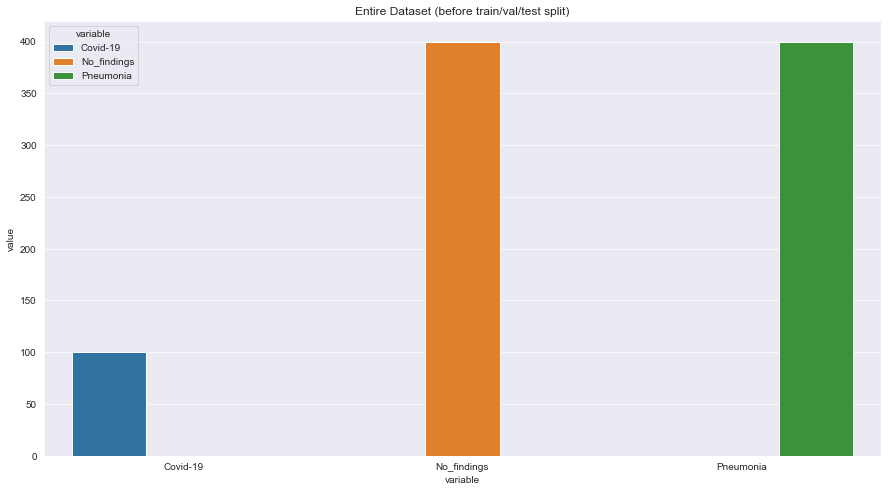

In [41]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict


def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train_data), plot_title="Entire Dataset (before train/val/test split)")

Text(0.5, 1.0, 'Test Set')

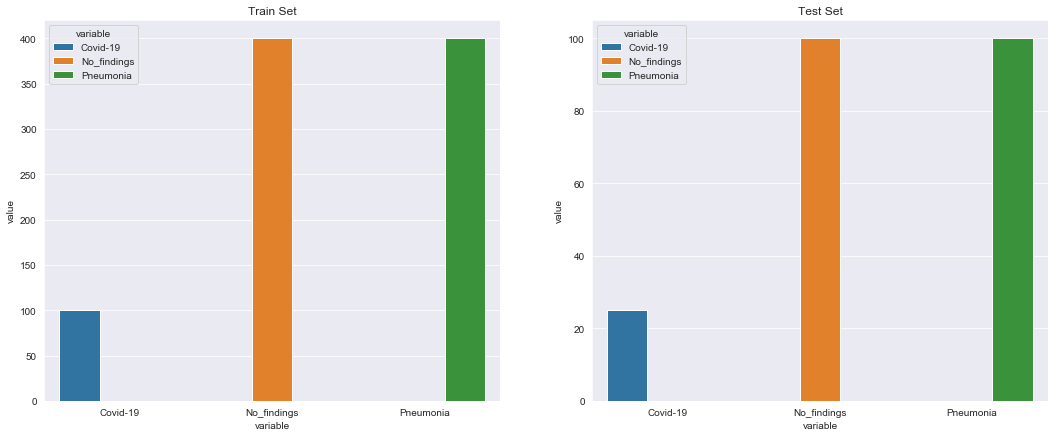

In [42]:
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    idx2class2 = {v: k for k, v in dataset_obj.class_to_idx.items()}
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:    
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx2class2[y_idx]
            count_dict[str(y_lbl)] += 1
    else: 
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx2class2[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,7))
plot_from_dict(get_class_distribution_loaders(train_loader, train_data), plot_title="Train Set", ax=axes[0])
plot_from_dict(get_class_distribution_loaders(test_loader, test_data), plot_title="Test Set", ax=axes[1])

In [43]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([32, 3, 256, 256])

In [44]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1,
        2, 1, 1, 2, 1, 2, 1, 1])

Output label tensor shape:  torch.Size([32])


In [45]:
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


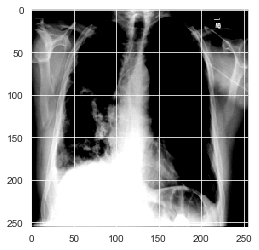

In [46]:
plt.imshow(single_image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


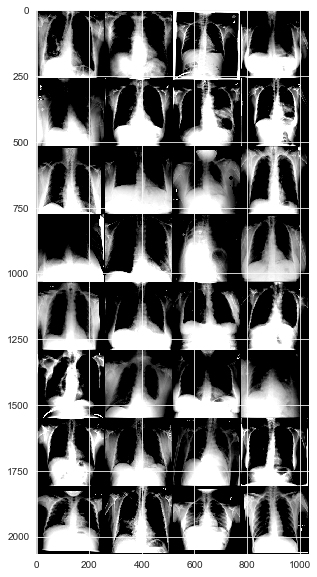

In [47]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)


def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )


def conv_layer(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(nf)  
    )
    

def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )


def maxpooling():
    return nn.MaxPool2d(2, stride=2)


class CovidCNN(nn.Module):
    def __init__(self):
        super(CovidCNN,self).__init__()
        self.covid = nn.Sequential(
            conv_block(3, 8),
            maxpooling(),
            conv_block(8, 16),
            maxpooling(),
            triple_conv(16, 32),
            maxpooling(),
            triple_conv(32, 64),
            maxpooling(),
            triple_conv(64, 128),
            maxpooling(),
            triple_conv(128, 256),
            conv_block(256, 128, size=1),
            conv_block(128, 256),
            conv_layer(256,3),
            nn.Flatten(),
            nn.Linear(507, 3)
        )
    def forward(self,x):
        x = self.covid(x)
        return x


model = CovidCNN()
model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

We're using => cuda
CovidCNN(
  (covid): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative

In [51]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc) * 100
    return acc


accuracy_stats = {
    'train': []
}
loss_stats = {
    'train': []
}

In [ ]:
# Train the Model
for epoch in range(EPOCHS):
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch).squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    print(f'Epoch {epoch+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')
    

In [ ]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [ ]:
#  y_pred_list = [i[0][0][0] for i in y_pred_list]
#  y_true_list = [i[0] for i in y_true_list]

In [ ]:
print(classification_report(y_true_list, y_pred_list))

In [ ]:
print(confusion_matrix(y_true_list, y_pred_list))

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)

In [ ]:
#Save the Trained Model
torch.save(model.state_dict(),'cnn_covid_artigo.pkl')
